In [1]:
#---------------------------------- IMPORTING!! ---------------------------------- 

%matplotlib notebook
import rebound
import numpy as np
import sys
from IPython.display import display, clear_output
from math import sqrt, log10, sin, cos, atan
import random as rnd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from tqdm import tqdm,tnrange
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from astropy import constants as const, units as u

In [2]:
#---------------------------------- CONSTANTS!! ---------------------------------- 

#All masses initialized in solar mass units:
m_hole = (4.0e6 * u.M_sun).value
m_bulge = (3.76e9/m_hole * u.M_sun).value
m_disk = (6.0e10/m_hole * u.M_sun).value
m_halo = (1.0e12/m_hole * u.M_sun).value

#All distances initialized in km:
r_hole = (7.0e10 * u.AU).to('km').value
r_peri = (1.0 * u.AU).to('km').value

#Bulge and disk parameters
ab = (2.0e7 * u.AU).to('km').value
ad = (5.7e8 * u.AU).to('km').value
bd = (6.2e7 * u.AU).to('km').value

#Additional constants
Gg = (const.G.to('km**3 / (M_sun s2)')).value #Gravitational constant in appropriate units
#scale = 1.6e9 # 8 kpc converted to AU
scale = (1.0e3 * u.pc).to('km').value #1 kpc converted to km
Mj = (9.54e-4 * u.M_sun).value #Mass of jupiter in solar mass units

In [3]:
#---------------------------------- DEFINING!! ---------------------------------- 

#Galaxy potential, taken from http://adsabs.harvard.edu/abs/2014ApJ...793..122K
#Note: There is a typo in that paper where "a_d" is said to be 2750 kpc, 
#it should be 2.75 kpc.

def migrationAccel(reb_sim):
    r = sqrt(ps[1].x**2+ps[1].y**2+ps[1].z**2)
    rho2 = ps[1].x**2+ps[1].y**2
    zbd = sqrt(ps[1].z**2+bd**2)
    
    #Components of halo force; smoothing function is necessary for integrator 
    #to handle logterm
    logterm = np.log(1.0+(r/r_hole))
    rterm = (r + r_hole)*(r**2)
    smoothing_func = lambda r: ((1.0/np.pi)*atan((r-1.0e8)/1.0e5) + 0.5)
    
    bulge_force = lambda r, coord: -m_bulge * coord/(r * (ab+r)**2)
    disk_force = lambda r, coord: -m_disk * coord/(rho2 + (ad + zbd)**2)**1.5
    halo_force = lambda r, coord: smoothing_func(r) * m_halo * coord * \
                ((logterm/r**3)-(1.0/rterm))
    
    ps[1].ax += bulge_force(r, ps[1].ax) + disk_force(r, ps[1].ax) + halo_force(r, ps[1].ax)
    ps[1].ay += bulge_force(r, ps[1].ay) + disk_force(r, ps[1].ay) + halo_force(r, ps[1].ay)
    ps[1].az += bulge_force(r, ps[1].az) + disk_force(r, ps[1].az) + halo_force(r, ps[1].az)
    
#Star mass determined from Salpeter's equation: Xi(m) =  1/(m**2.35)
#Integrating Xi(m') from -infty to m gives CDF(m) = 1/(m**1.35),
#produces a probability between [0,1].
#mstar_func(x) takes CDF(m) and solves for m as a function of probability 0 <= x <= 1. 

mstar_func = lambda x: (1.0/x**1.35 * u.M_sun).value

#Star radius determined via mass-radius power law, returns value in km units:
def rstar_func(m_star):
    if m_star <= 1.0:
        r = m_star**0.8
    else: 
        r = m_star**0.57
    
    r_star = ((r * u.R_sun).to('km')).value
    return r_star

#Binding energy spread, dependent on r of fragment (from Kochanek 1993)
Delta_E = lambda r: Gg*m_hole*r/(r_peri**2)

#The tidal radius (in km) for the star, with m_star and r_star being in solar mass and radii, respectively:
#Taken from http://arxiv.org/pdf/1505.01093v1.pdf
r_tidal = lambda m_star, r_star: 7.0e7*((m_hole/1.0e6)** (1. / 3))*m_star*r_star 

In [4]:
#---------------------------------- INTEGRATING!! ---------------------------------- 
Nstars = 1
#nfrag = rnd.randint(100, 300)
nfrag = 10
Nout = 200

t_start = 0.0
t_end = 10000.0

posx = [[[] for y in range(nfrag)] for x in range(Nstars)]
posy = [[[] for y in range(nfrag)] for x in range(Nstars)]
posz = [[[] for y in range(nfrag)] for x in range(Nstars)]

star_masses=[]
star_radii=[]
frag_masses=[]
sphere_points=[]

for star in tnrange(Nstars, desc='Star', leave=False):
    #Draw mass and radius of the star
    x = rnd.random()
    m_star = mstar_func(x) #in solar masses
    r_star = rstar_func(m_star) #in km, consistent with other distances
    
    star_masses.append(m_star)
    star_radii.append((r_star * u.km).to('Rsun').value)
    
    r_t = r_tidal(m_star, (r_star * u.km).to('Rsun').value)

    #Distance of each fragment
    rads = [float(f)/float(nfrag+1)*r_star for f in range(nfrag+1)]
    rads.pop(0)
    
    #Velocity spread for star fragments, determined by binding energy
    vels = [sqrt(2*Delta_E(r))for r in rads] #in km/s
    
    frag_masses.append([])
    
    for frag in tnrange(nfrag, desc='Fragment', leave=False):
#         #Draw mass of fragments, from random normal dist. of clump masses centered around
#         #mean mass specified in Coughlin 2016 for gamma = 2
#         mu, sigma = 2.6*Mj, 0.3*Mj # mean and standard deviation
#         m_frag = (np.random.normal(mu, sigma)*u.Msun).value
#         frag_masses[star].append(m_frag)
        
        #Set position of fragment; random sphere point picking
        u1 = rnd.uniform(-1.0,1.0)
        th1 = rnd.uniform(0., 2.*np.pi)
        r = rads[frag]
        posvec = [sqrt(1.0-(u1)**2)*cos(th1),sqrt(1.0-(u1)**2)*sin(th1),u1] #position vector
        sphere_points.append(posvec)
        
        #Randomly draw velocity vector by taking cross product of position vec and 
        #a random unit vector
        u2 = rnd.uniform(-1.0,1.0)
        th2 = rnd.uniform(0., 2.*np.pi)
        vec2 = [sqrt(1.0-(u2)**2)*cos(th2),sqrt(1.0-(u2)**2)*sin(th2),u2]
        velvec = np.cross(posvec, vec2)
        
        n = np.linalg.norm(velvec)
        vel = vels[frag]
        velvec = [vel*v/n for v in velvec] #velocity vector

        #Add particle
        sim.add(m=0.0, x=posvec[0],y=posvec[1],z=posvec[2],vx=velvec[0],\
                vy=velvec[1],vz=velvec[2])
        sim.N_active = 1
        ps = sim.particles

        times = np.linspace(0.0, 200.0*((ab)**(1.5)/sqrt(m_bulge))*2.*np.pi, Nout)
        #times = np.linspace(t_start, t_end, Nout)
        for ti, time in enumerate(times):
            #print(time)
            sim.integrate(time, exact_finish_time=1)
            posx[star][frag].append(ps[1].x/scale)
            posy[star][frag].append(ps[1].y/scale)
            posz[star][frag].append(ps[1].z/scale)

In [ ]:
#---------------------------------- CHECKING!! ---------------------------------- 
print star_masses, '\n'
print star_radii, '\n'
print vels, '\n'
print [(r*u.km).to('R_sun').value for r in rads], '\n'
print posx[2][29]

<IPython.core.display.Javascript object>


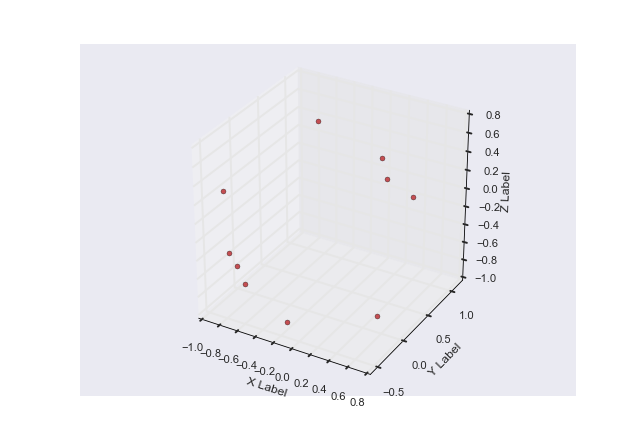

In [5]:
#---------------------------------- SPHERE POINTS!! ---------------------------------- 
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
for posvec in sphere_points:
    xs = posvec[0]
    ys = posvec[1]
    zs = posvec[2]
    ax1.scatter(xs, ys, zs, c='r', marker='o')
    
ax1.set_aspect('equal')
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')

plt.show()

<IPython.core.display.Javascript object>


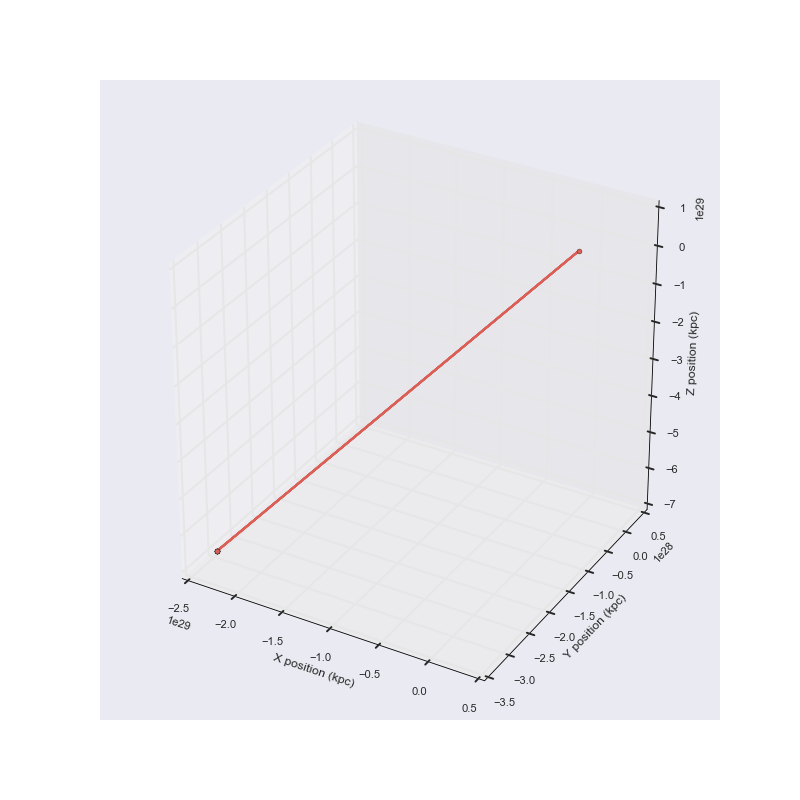

In [6]:
#---------------------------------- PLOTTING!! ---------------------------------- 

fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(111, projection='3d')
colors = sns.color_palette("hls", Nstars).as_hex()

for star in range(Nstars):
    for i in range(nfrag):
        ax2.plot(posx[star][i],posy[star][i],posz[star][i], c = colors[star]);
        ax2.scatter([posx[star][i][-1]],[posy[star][i][-1]],[posz[star][i][-1]],c = colors[star]);

ax2.set_xlabel('X position (kpc)')
ax2.set_ylabel('Y position (kpc)')
ax2.set_zlabel('Z position (kpc)')

<IPython.core.display.Javascript object>


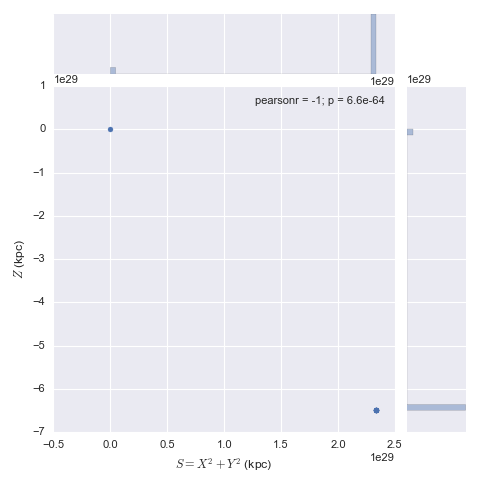

<IPython.core.display.Javascript object>


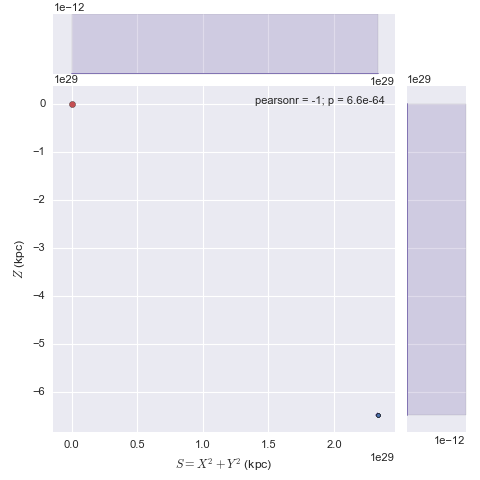

In [7]:
#---------------------------------- VISUALIZING!! ---------------------------------- 
data_sz = []
data_xy_0=[]

for star in range(Nstars):
    for i in range(nfrag):
        point1 = [sqrt(posx[star][i][-1]**2 + posy[star][i][-1]**2), posz[star][i][-1]]
        point2 = [posx[star][i][-1], posy[star][i][-1], posz[star][i][-1]]
        data_sz.append(point1)
#         if -1.0 < point2[2] and point2[2] < 1.0: #plot points within a kpc of the sun in the z-direction
#             data_xy_0.append([point2[0],point2[1]])
        
fragdata_sz = np.array([point for point in data_sz])
df_sz = pd.DataFrame(fragdata_sz, columns=["s", "z"])

# fragdata_xy_0 = np.array([point for point in data_xy_0])
# df_xy_0 = pd.DataFrame(fragdata_xy_0, columns=["x", "y"])

sun_pos_sz = pd.DataFrame([[0,0]], columns=['s', 'z'])
# sun_pos_xy = pd.DataFrame([[8,0]], columns=['x', 'y'])

#Scatter plots - S (sqrt(X**2+Y**2)) and Z
f = sns.jointplot(x="s", y="z", data=df_sz);
f.set_axis_labels("$S = X^2 + Y^2$ (kpc)", "$Z$ (kpc)");

#Density plot - S and Z
g = sns.jointplot(x="s", y="z", data=df_sz, kind="kde", color="m")
g.plot_joint(plt.scatter, c="b", s=10, marker="o")
g.x = sun_pos_sz.s
g.y = sun_pos_sz.z
g.plot_joint(plt.scatter, c="r", s=30, marker="o")

g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$S = X^2 + Y^2$ (kpc)", "$Z$ (kpc)");

# #Density plot - X and Y
# h = sns.jointplot(x="x", y="y", data=df_xy_0, kind="kde", color="m")
# h.plot_joint(plt.scatter, c="b", s=10, marker="o")
# h.x = sun_pos_xy.x
# h.y = sun_pos_xy.y
# h.plot_joint(plt.scatter, c="r", s=30, marker="o")

# h.ax_joint.collections[0].set_alpha(0)
# h.set_axis_labels("$X$ (kpc), $Z\approx 0$", "$Y$ (kpc), $Z\approx 0$");